# Discriminant Analysis of Principal Components
## Temporal Structure of Blackfin tuna

In [44]:
library(adegenet) 
library(dplyr)
library(tidyr)
library(magrittr)
library(ggpubr)
library(plotly)
set.seed(6969)
my_pal <- c("#f1c232", "#d08120", "#54438a", "#655595", "#2a2145","#66b2b2", "#008080", "#006666", "#ff8181")

Load in the file(s)

In [7]:
infile <- "../inputfiles/bft.kinrm.gen"
bft <- read.genepop(infile, ncode = 3L, quiet = T)
metadata <- read.csv("../inputfiles/bft.kinrm.strata", sep = ",", header = T)

Adding Population-Year as the `pop` information

Make sure the metadata is in the same order as the indNames in the genind object

In [8]:
metadata <- metadata[match(indNames(bft), metadata$name),]

In [9]:
metadata$locyear <- paste(metadata$pop4, metadata$year, sep = "-")

pop(bft) <- metadata$locyear
yearID <- metadata$year
localID <- metadata$pop4
regionID <- metadata$pop3

### Final Optimal number of Principal Components
Use cross validation to determine optimal number of PCs to keep. The first cross-validation is performed between 1 and 300 in increments of 10. This can be considered a "coarse" search.

[1] "60"

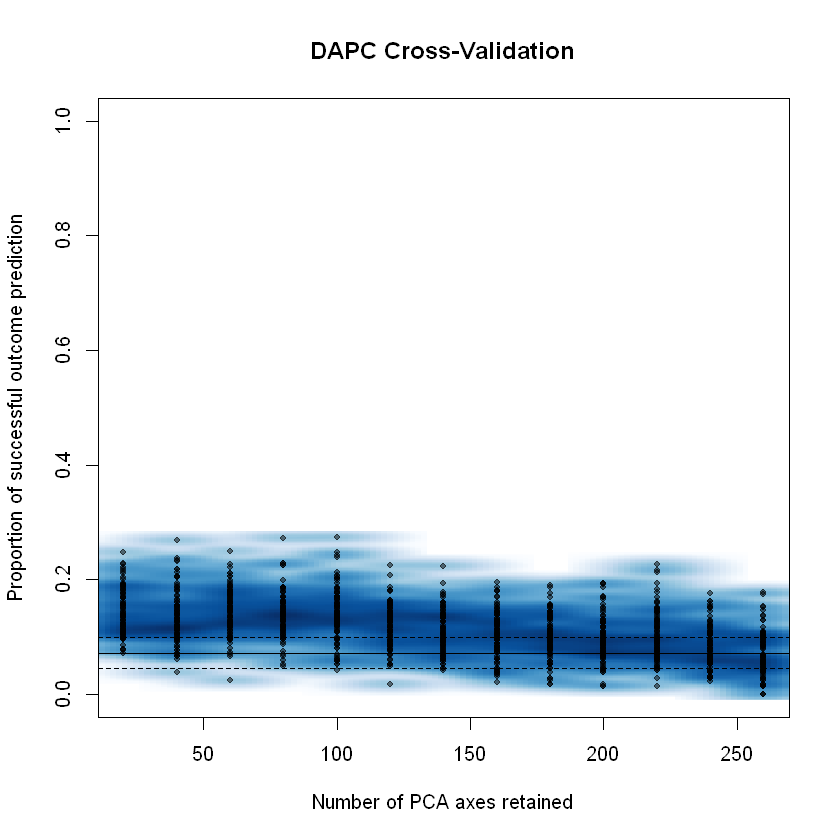

In [16]:
crossval <- xvalDapc(tab(bft, NA.method="mean"), pop(bft), n.pca.max=300, n.rep=100,  parallel = "multicore", ncpus = 4)
crossval$`Number of PCs Achieving Highest Mean Success`

It suggests around 60 PCs, so now perform a "fine" search of 50 to 70 in increments of 1

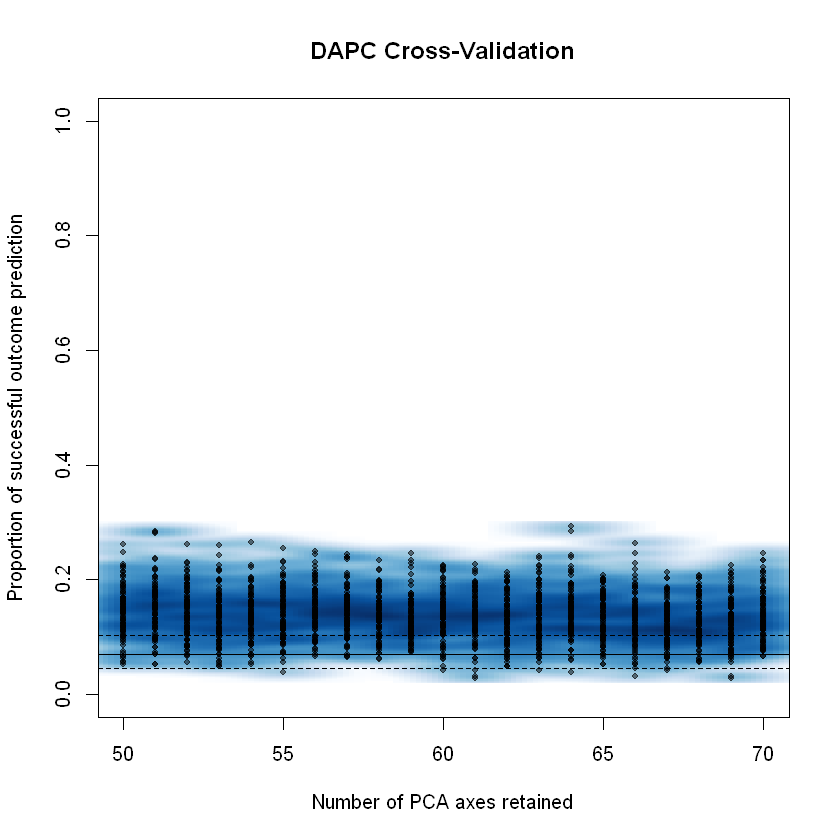

In [17]:
dapc <- xvalDapc(tab(bft, NA.method="mean"), pop(bft), n.pca=50:70, n.rep=100,  parallel = "multicore", ncpus = 4)

Save the optimal PC number

In [18]:
pcval <- dapc$DAPC$n.pca
print(paste("Optimal PC:", pcval))

[1] "Optimal PC: 51"


### K-means clustering
Iteratively perform K-means clustering from K-values 1 to 9, each value of K performed 50 times.

In [19]:
maxK <- 9
myMat <- matrix(nrow=50, ncol=maxK)
colnames(myMat) <- 1:maxK
for(i in 1:nrow(myMat)){
  grp <- find.clusters(bft, n.pca = pcval, choose.n.clust = FALSE,  max.n.clust = maxK)
  myMat[i,] <- grp$Kstat
}

Format the matrix for plotting

In [20]:
k_df <- reshape2::melt(myMat)
colnames(k_df)[1:3] <- c("Group", "K", "BIC")
k_df$K <- as.factor(k_df$K)

Plot the results

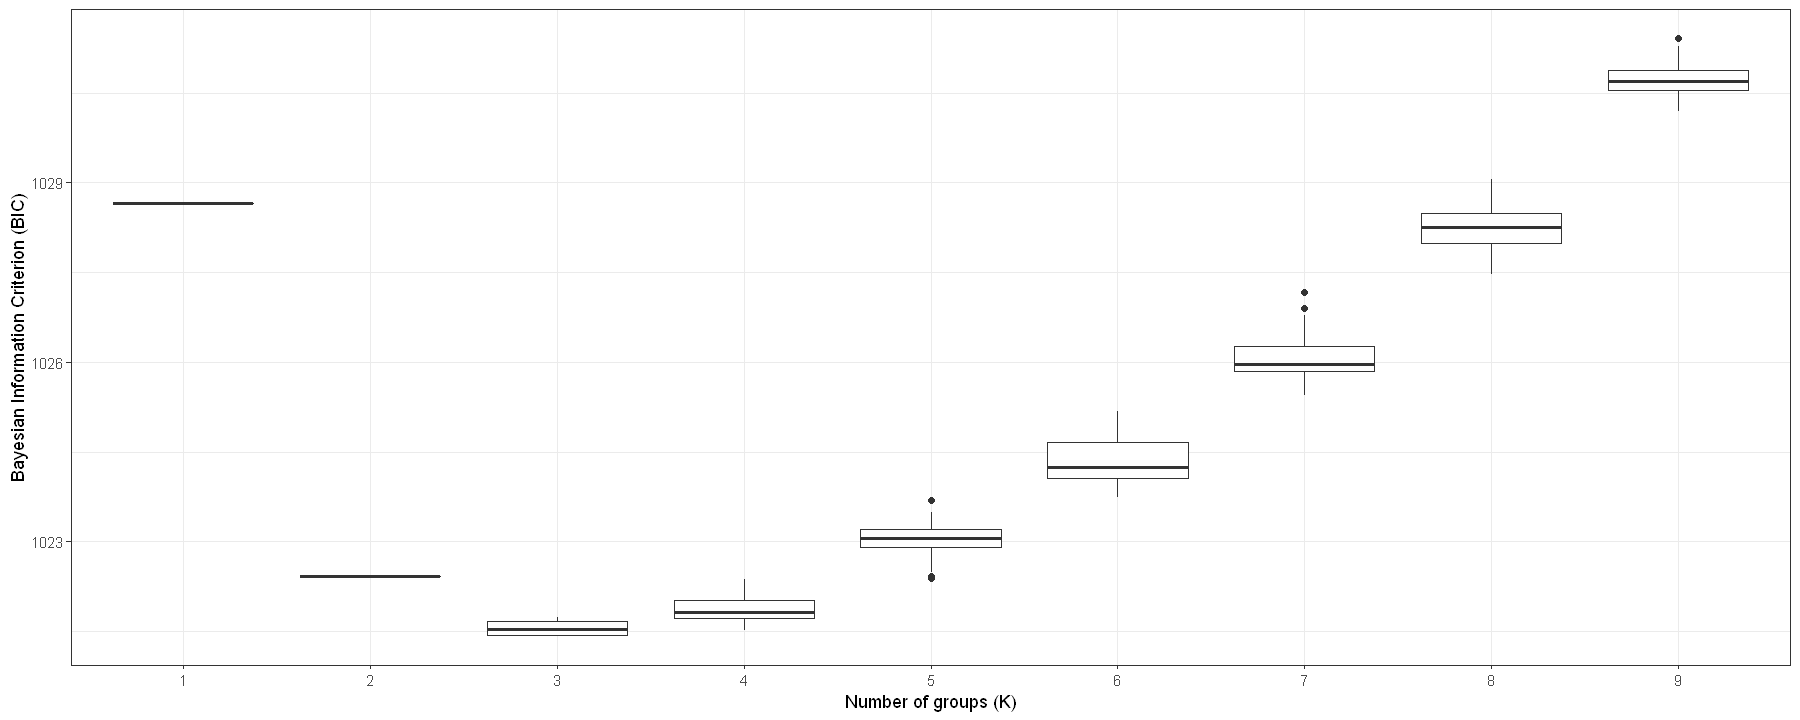

In [21]:
k_plot <- k_df %>% 
  ggplot(aes(x = K, y = BIC)) +
  geom_boxplot() +
  theme_bw() +
  ylab("Bayesian Information Criterion (BIC)") +
  xlab("Number of groups (K)")

options(repr.plot.width=15, repr.plot.height=6)
k_plot

Get the population assignments from K-means clustering with K = 3

In [29]:
kmeans3 <- find.clusters(bft, n.pca = pcval,  n.clust = 3)

Retain _de novo_ k-means assignments to use for the DAPC

In [35]:
kmeans.grp <- kmeans3$grp

### DAPC
Perform DAPC again, this time using the optimal PC and the K-means assignments

In [36]:
dapc.res <- dapc(bft, pop = kmeans.grp, n.pca = pcval, n.da = 5)

In [41]:
head(df)

,rownames(dapc.res$ind.coord),dapc.res$grp,localID,LD1,LD2
,<chr>,<fct>,<chr>,<dbl>,<dbl>
BRZ_1261,BRZ_1261,2,BRZ,-0.7453012,-0.5098041
BRZ_1269,BRZ_1269,1,BRZ,-1.4685439,1.6693026
BRZ_1270,BRZ_1270,2,BRZ,-0.7800891,-2.8247285
BRZ_1271,BRZ_1271,1,BRZ,-1.3242737,2.3650824
BRZ_1275,BRZ_1275,2,BRZ,-1.2359341,-2.4365306
BRZ_1276,BRZ_1276,2,BRZ,-0.7042250,-2.1370947


Format the DAPC output for scatterplot

In [66]:
df <- as.data.frame(dapc.res$ind.coord, col.names = colnames(dapc.res$ind.coord))
df <- cbind(rownames(dapc.res$ind.coord), dapc.res$grp, localID, df)
names(df) <- c("name", "year", "locality", "LD1", "LD2")
df %<>% mutate(year = factor(yearID, levels = c(2015, 2016, 2017, 2018), ordered = TRUE))
df$locality <- factor(localID, levels = c("BRZ", "BRZSP", "MRT", "VZ", "PR", "TX", "PNS", "KEY", "SCA"), ordered = TRUE)
df$region <- factor(regionID, levels = c("ATL","GULF","CRB", "BRZ"))
df %<>% group_by(year) %>% 
  mutate(centroid1.yr = mean(LD1), centroid2.yr = mean(LD2)) %>%
  group_by(locality) %>%
  mutate(centroid1.loc = mean(LD1), centroid2.loc = mean(LD2)) %>%
  group_by(region) %>%
  mutate(centroid1.reg = mean(LD1), centroid2.reg = mean(LD2))
head(df)

name,year,locality,LD1,LD2,region,centroid1.yr,centroid2.yr,centroid1.loc,centroid2.loc,centroid1.reg,centroid2.reg
<chr>,<ord>,<ord>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRZ_1261,2016,BRZ,-0.7453012,-0.5098041,BRZ,-0.1422777,-0.1142778,-0.589425,-0.7234724,-0.7225945,-0.3684561
BRZ_1269,2016,BRZ,-1.4685439,1.6693026,BRZ,-0.1422777,-0.1142778,-0.589425,-0.7234724,-0.7225945,-0.3684561
BRZ_1270,2016,BRZ,-0.7800891,-2.8247285,BRZ,-0.1422777,-0.1142778,-0.589425,-0.7234724,-0.7225945,-0.3684561
BRZ_1271,2016,BRZ,-1.3242737,2.3650824,BRZ,-0.1422777,-0.1142778,-0.589425,-0.7234724,-0.7225945,-0.3684561
BRZ_1275,2016,BRZ,-1.2359341,-2.4365306,BRZ,-0.1422777,-0.1142778,-0.589425,-0.7234724,-0.7225945,-0.3684561
BRZ_1276,2016,BRZ,-0.7042250,-2.1370947,BRZ,-0.1422777,-0.1142778,-0.589425,-0.7234724,-0.7225945,-0.3684561


## Plot by Locality

In [62]:
options(repr.plot.width=10, repr.plot.height=8)

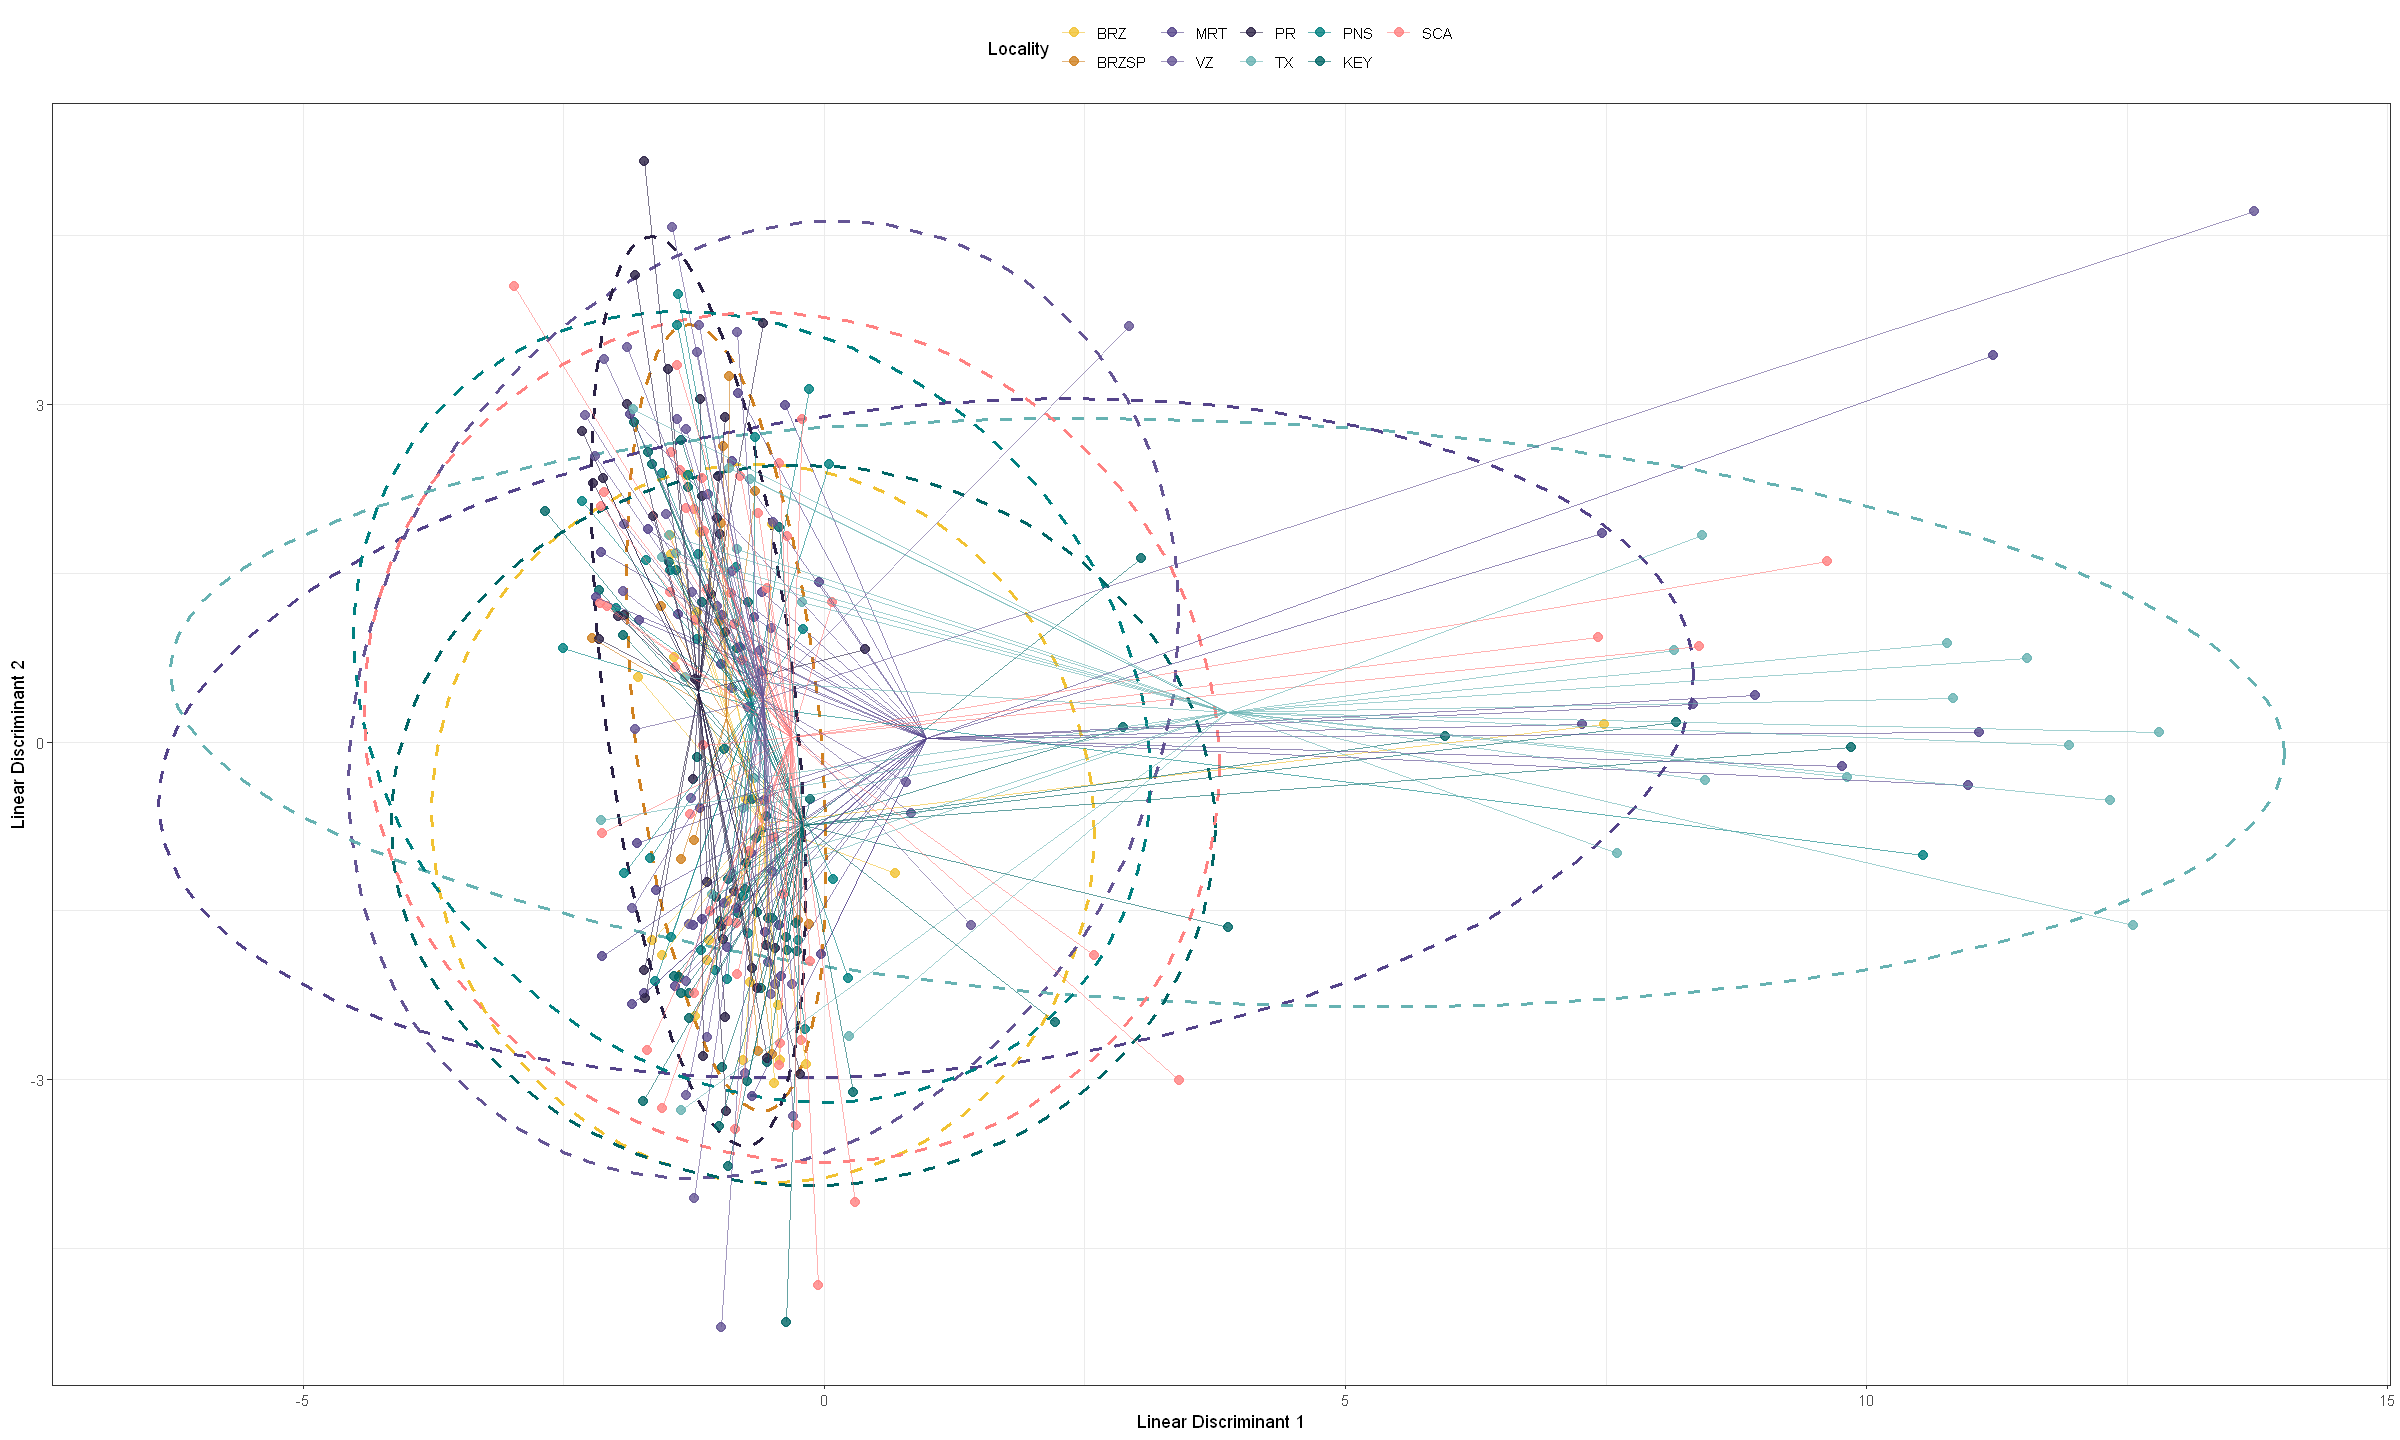

In [95]:
dapc.plt.loc <- df %>% 
  ggplot(aes(x = LD1, y = LD2)) +
  stat_ellipse(linetype = 2, size = 1, show.legend = FALSE, type = "norm", level = 0.75, segments = 100, aes(color = locality)) +
  geom_point(size = 2.4, alpha = 0.8, aes(color = locality, fill = locality)) +
  geom_segment(data = df, alpha = 0.6, aes(x = centroid1.loc, y = centroid2.loc, xend = LD1, yend = LD2, color = locality)) +
  xlab("Linear Discriminant 1") +
  ylab("Linear Discriminant 2") +
  scale_color_manual(values=my_pal, name = "Locality") +
  scale_fill_manual(values=c(paste(my_pal, "96", sep = "")), name = "Locality") +
  theme_bw() +
  theme(legend.position = "top")

dapc.plt.loc

## Plot by Region

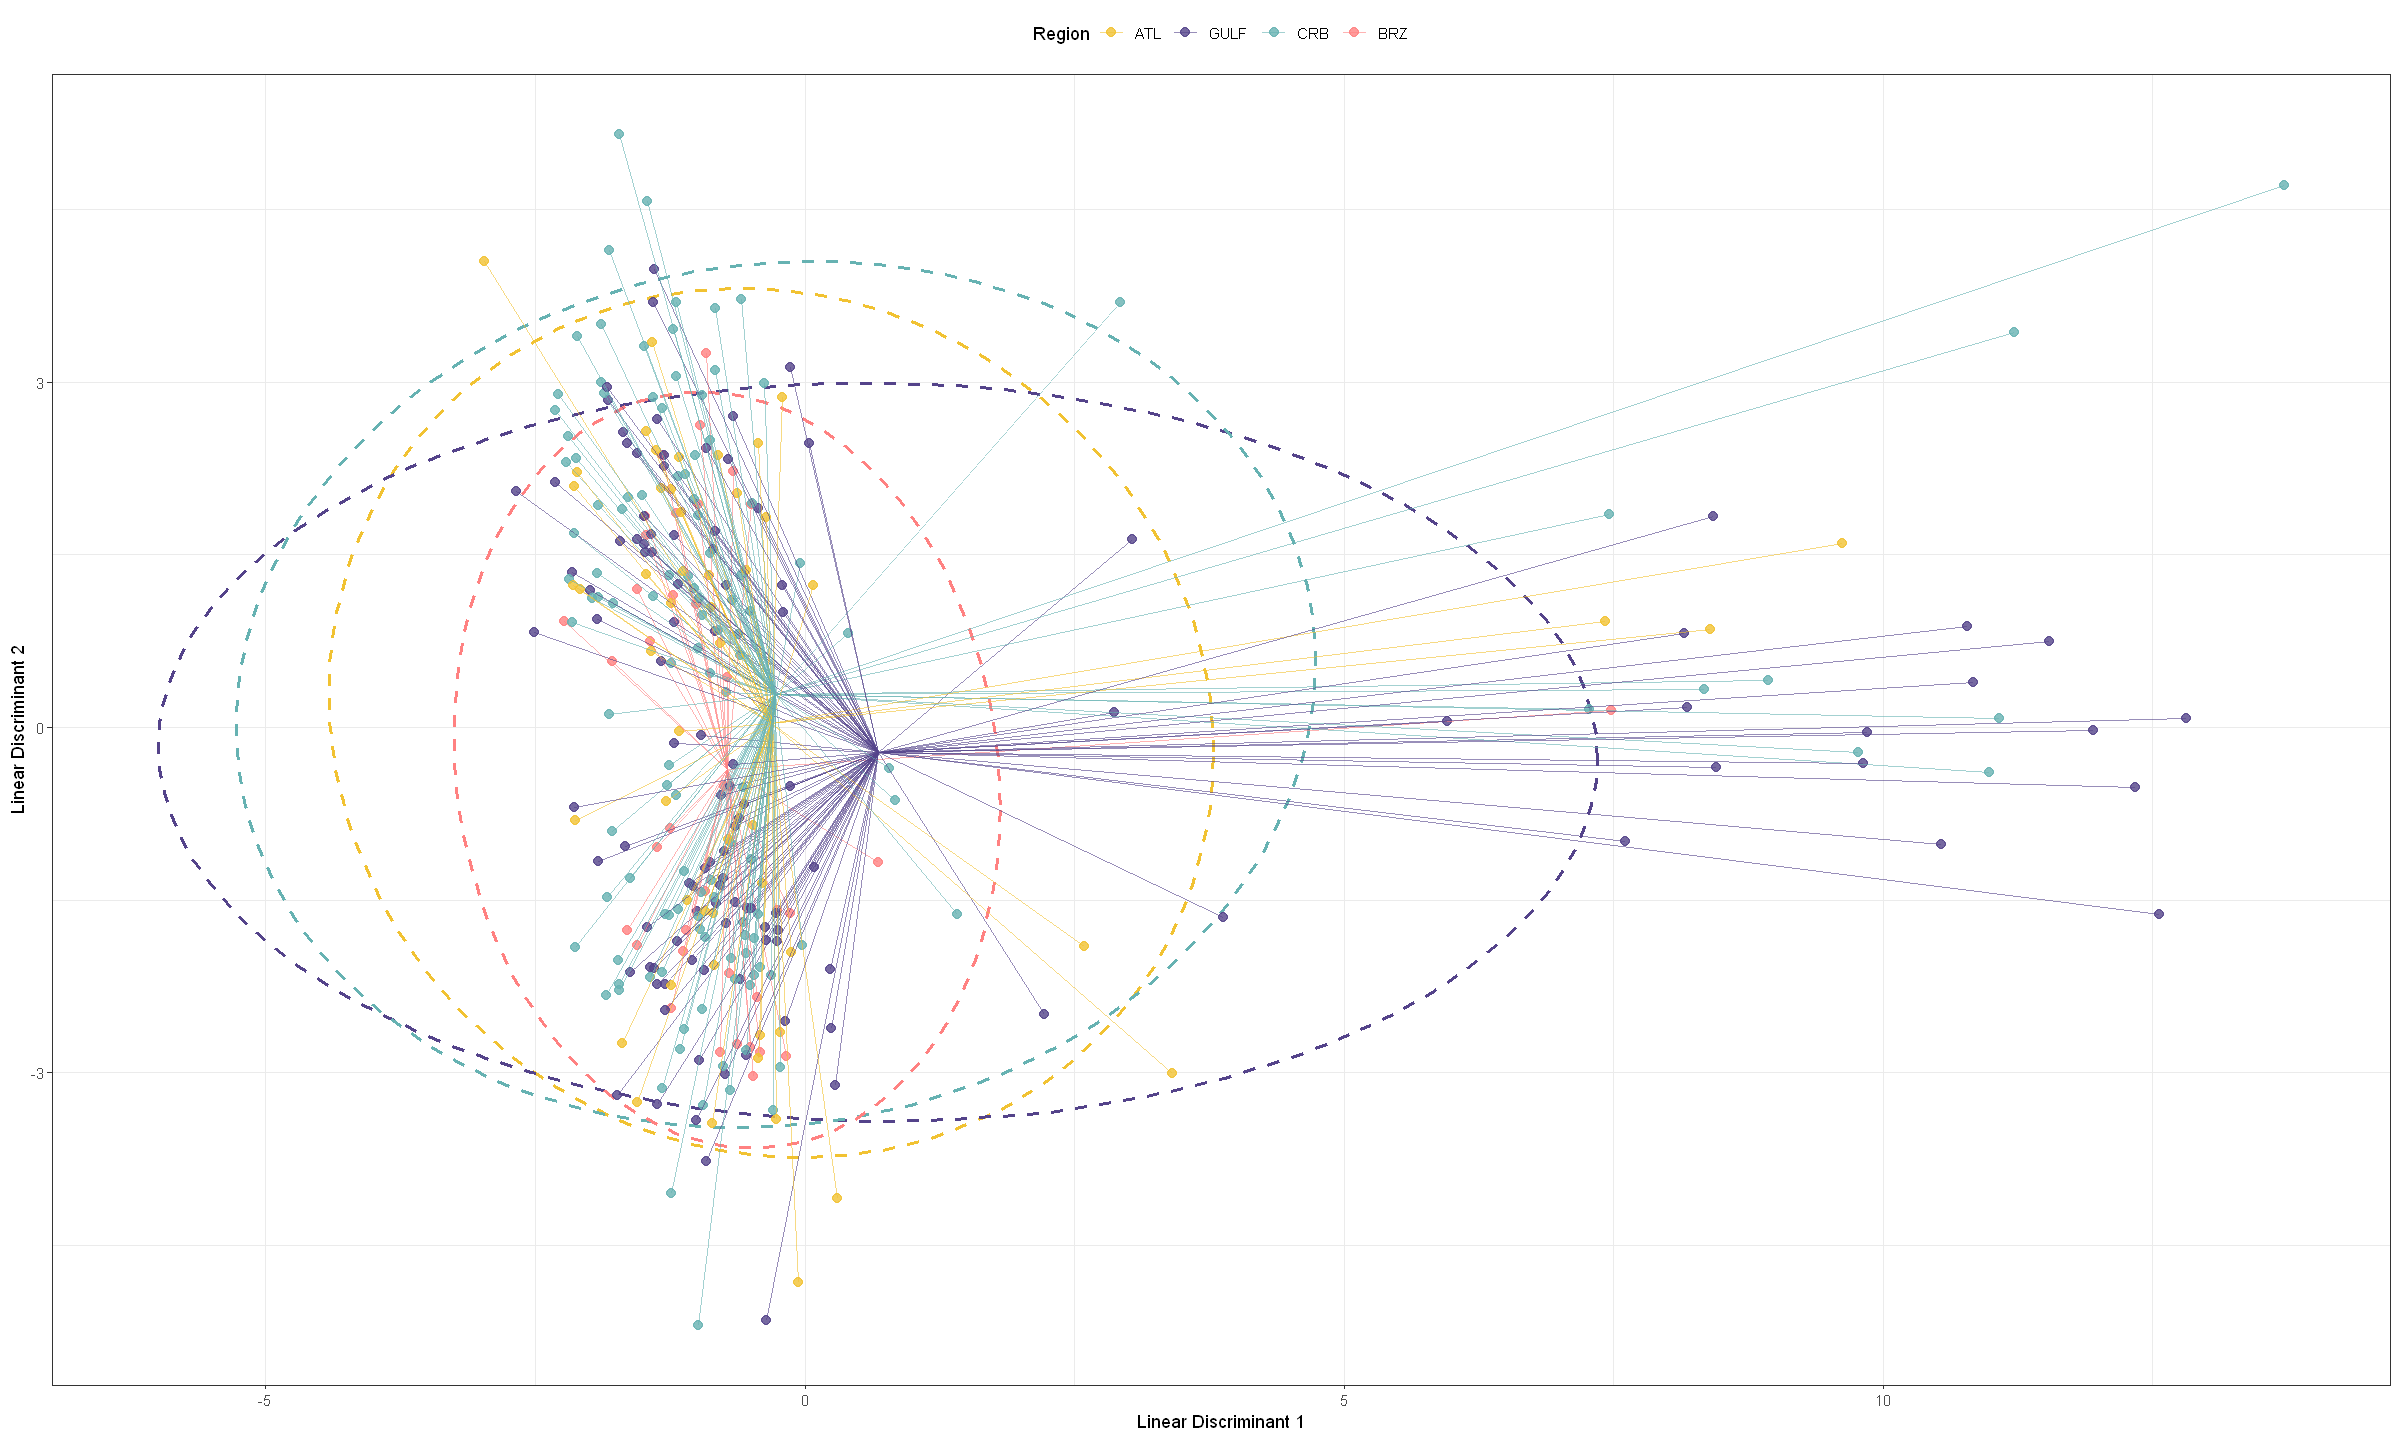

In [94]:
dapc.plt.region <- df %>% 
  ggplot(aes(x = LD1, y = LD2)) +
  stat_ellipse(linetype = 2, size = 1, show.legend = FALSE, type = "norm", level = 0.75, segments = 100, aes(color = region)) +
  geom_point(size = 2.4, alpha = 0.8, aes(color = region, fill = region)) +
  geom_segment(data = df, alpha = 0.6, aes(x = centroid1.reg, y = centroid2.reg, xend = LD1, yend = LD2, color = region)) +
  xlab("Linear Discriminant 1") +
  ylab("Linear Discriminant 2") +
  scale_color_manual(values=my_pal[c(1,3,6,9)], name = "Region") +
  scale_fill_manual(values=c(paste(my_pal[c(1,3,6,9)], "96", sep = "")), name = "Region") +
  theme_bw() +
  theme(legend.position="top")

dapc.plt.region

## Plot by Year

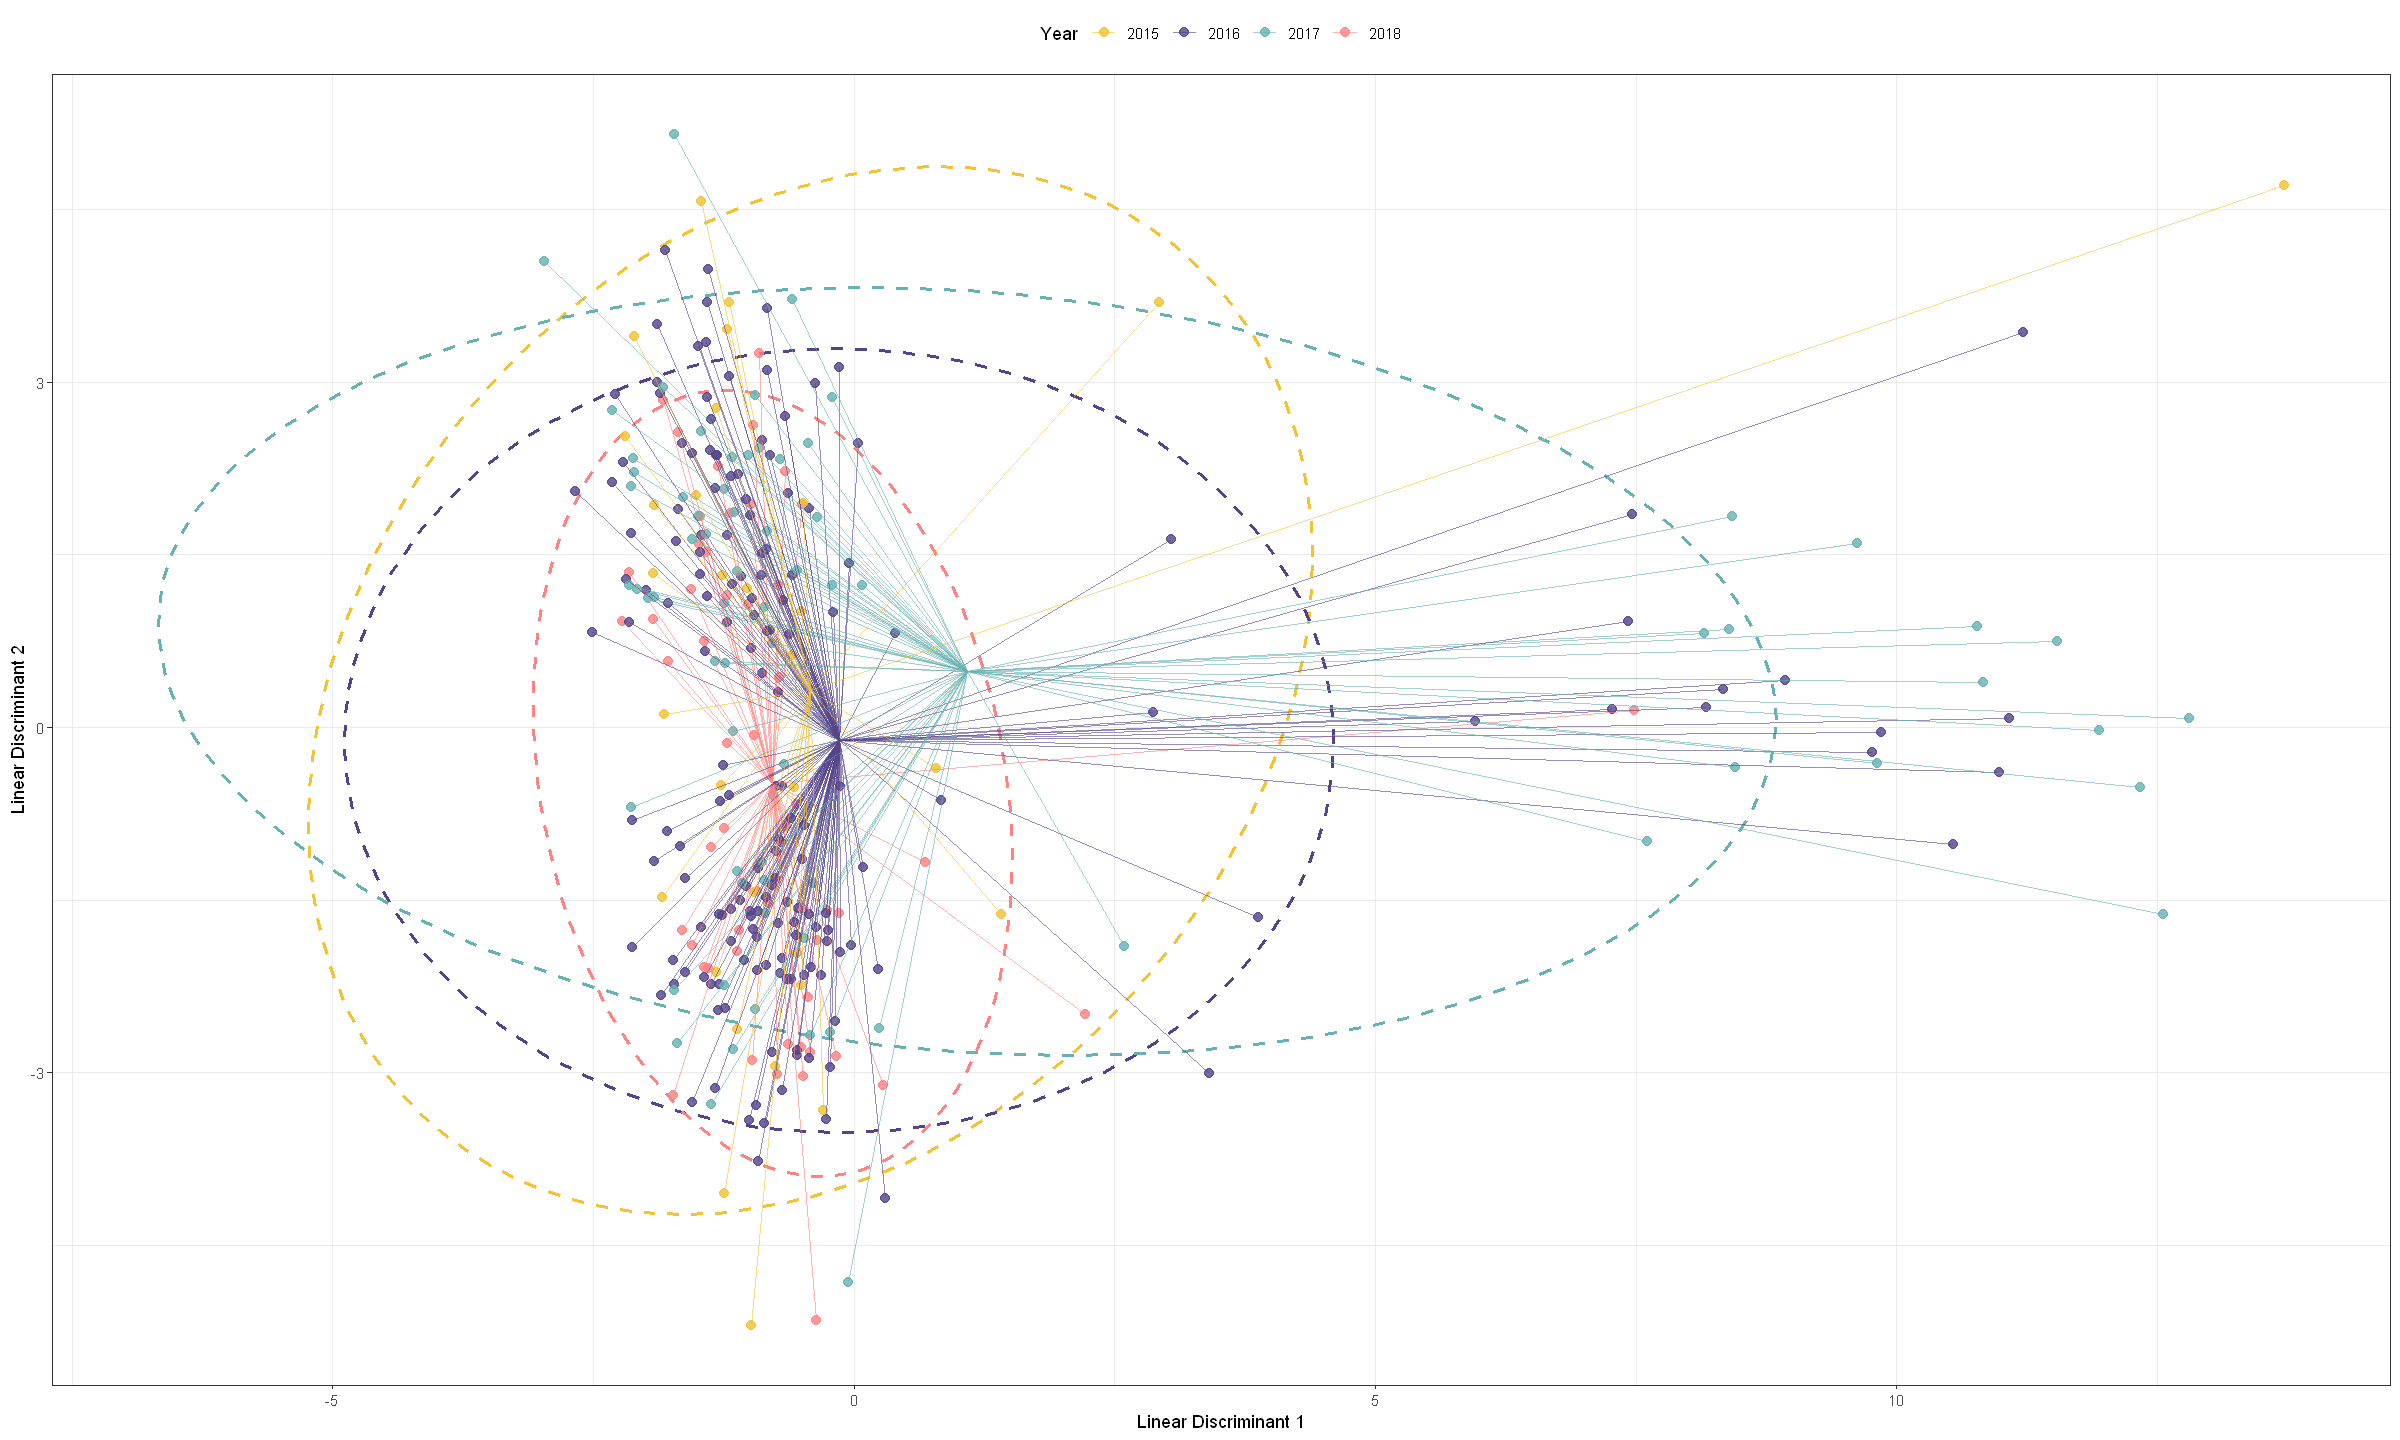

In [96]:
dapc.plt.year <- df %>% 
  ggplot(aes(x = LD1, y = LD2)) +
  stat_ellipse(linetype = 2, size = 1, show.legend = FALSE, type = "norm", level = 0.75, segments = 100, aes(color = year)) +
  geom_point(size = 2.4, alpha = 0.8, aes(color = year, fill = year)) +
  geom_segment(data = df, alpha = 0.6, aes(x = centroid1.yr, y = centroid2.yr, xend = LD1, yend = LD2, color = year)) +
  xlab("Linear Discriminant 1") +
  ylab("Linear Discriminant 2") +
  scale_color_manual(values=my_pal[c(1,3,6,9)], name = "Year") +
  scale_fill_manual(values=c(paste(my_pal[c(1,3,6,9)], "96", sep = "")), name = "Year") +
  theme_bw() +
  theme(legend.position="top")

dapc.plt.year

### Posterior Membership Plot
Making the stacked barplot, similar to how STRUCTURE results are presented

In [57]:
tmp <- as.data.frame(dapc.res$posterior)
tmp <- cbind(indNames(bft), bft$pop, tmp)
names(tmp) <- c("name", "origin", "1", "2", "3")
tmp$origin <- metadata$pop4
tmp$origin <- paste(metadata$pop4, metadata$year, sep = "\n")
assignments <- pivot_longer(tmp, c(-name, -origin), names_to = "assignment", values_to = "posterior")
head(assignments)

name,origin,assignment,posterior
<chr>,<chr>,<chr>,<dbl>
BRZ_1261,BRZ 2016,1,1.008744e-01
BRZ_1261,BRZ 2016,2,8.991256e-01
BRZ_1261,BRZ 2016,3,5.373823e-25
BRZ_1269,BRZ 2016,1,9.986704e-01
BRZ_1269,BRZ 2016,2,1.329644e-03
BRZ_1269,BRZ 2016,3,8.120190e-29


Plot the data

In [78]:
options(repr.plot.width=20, repr.plot.height=5)

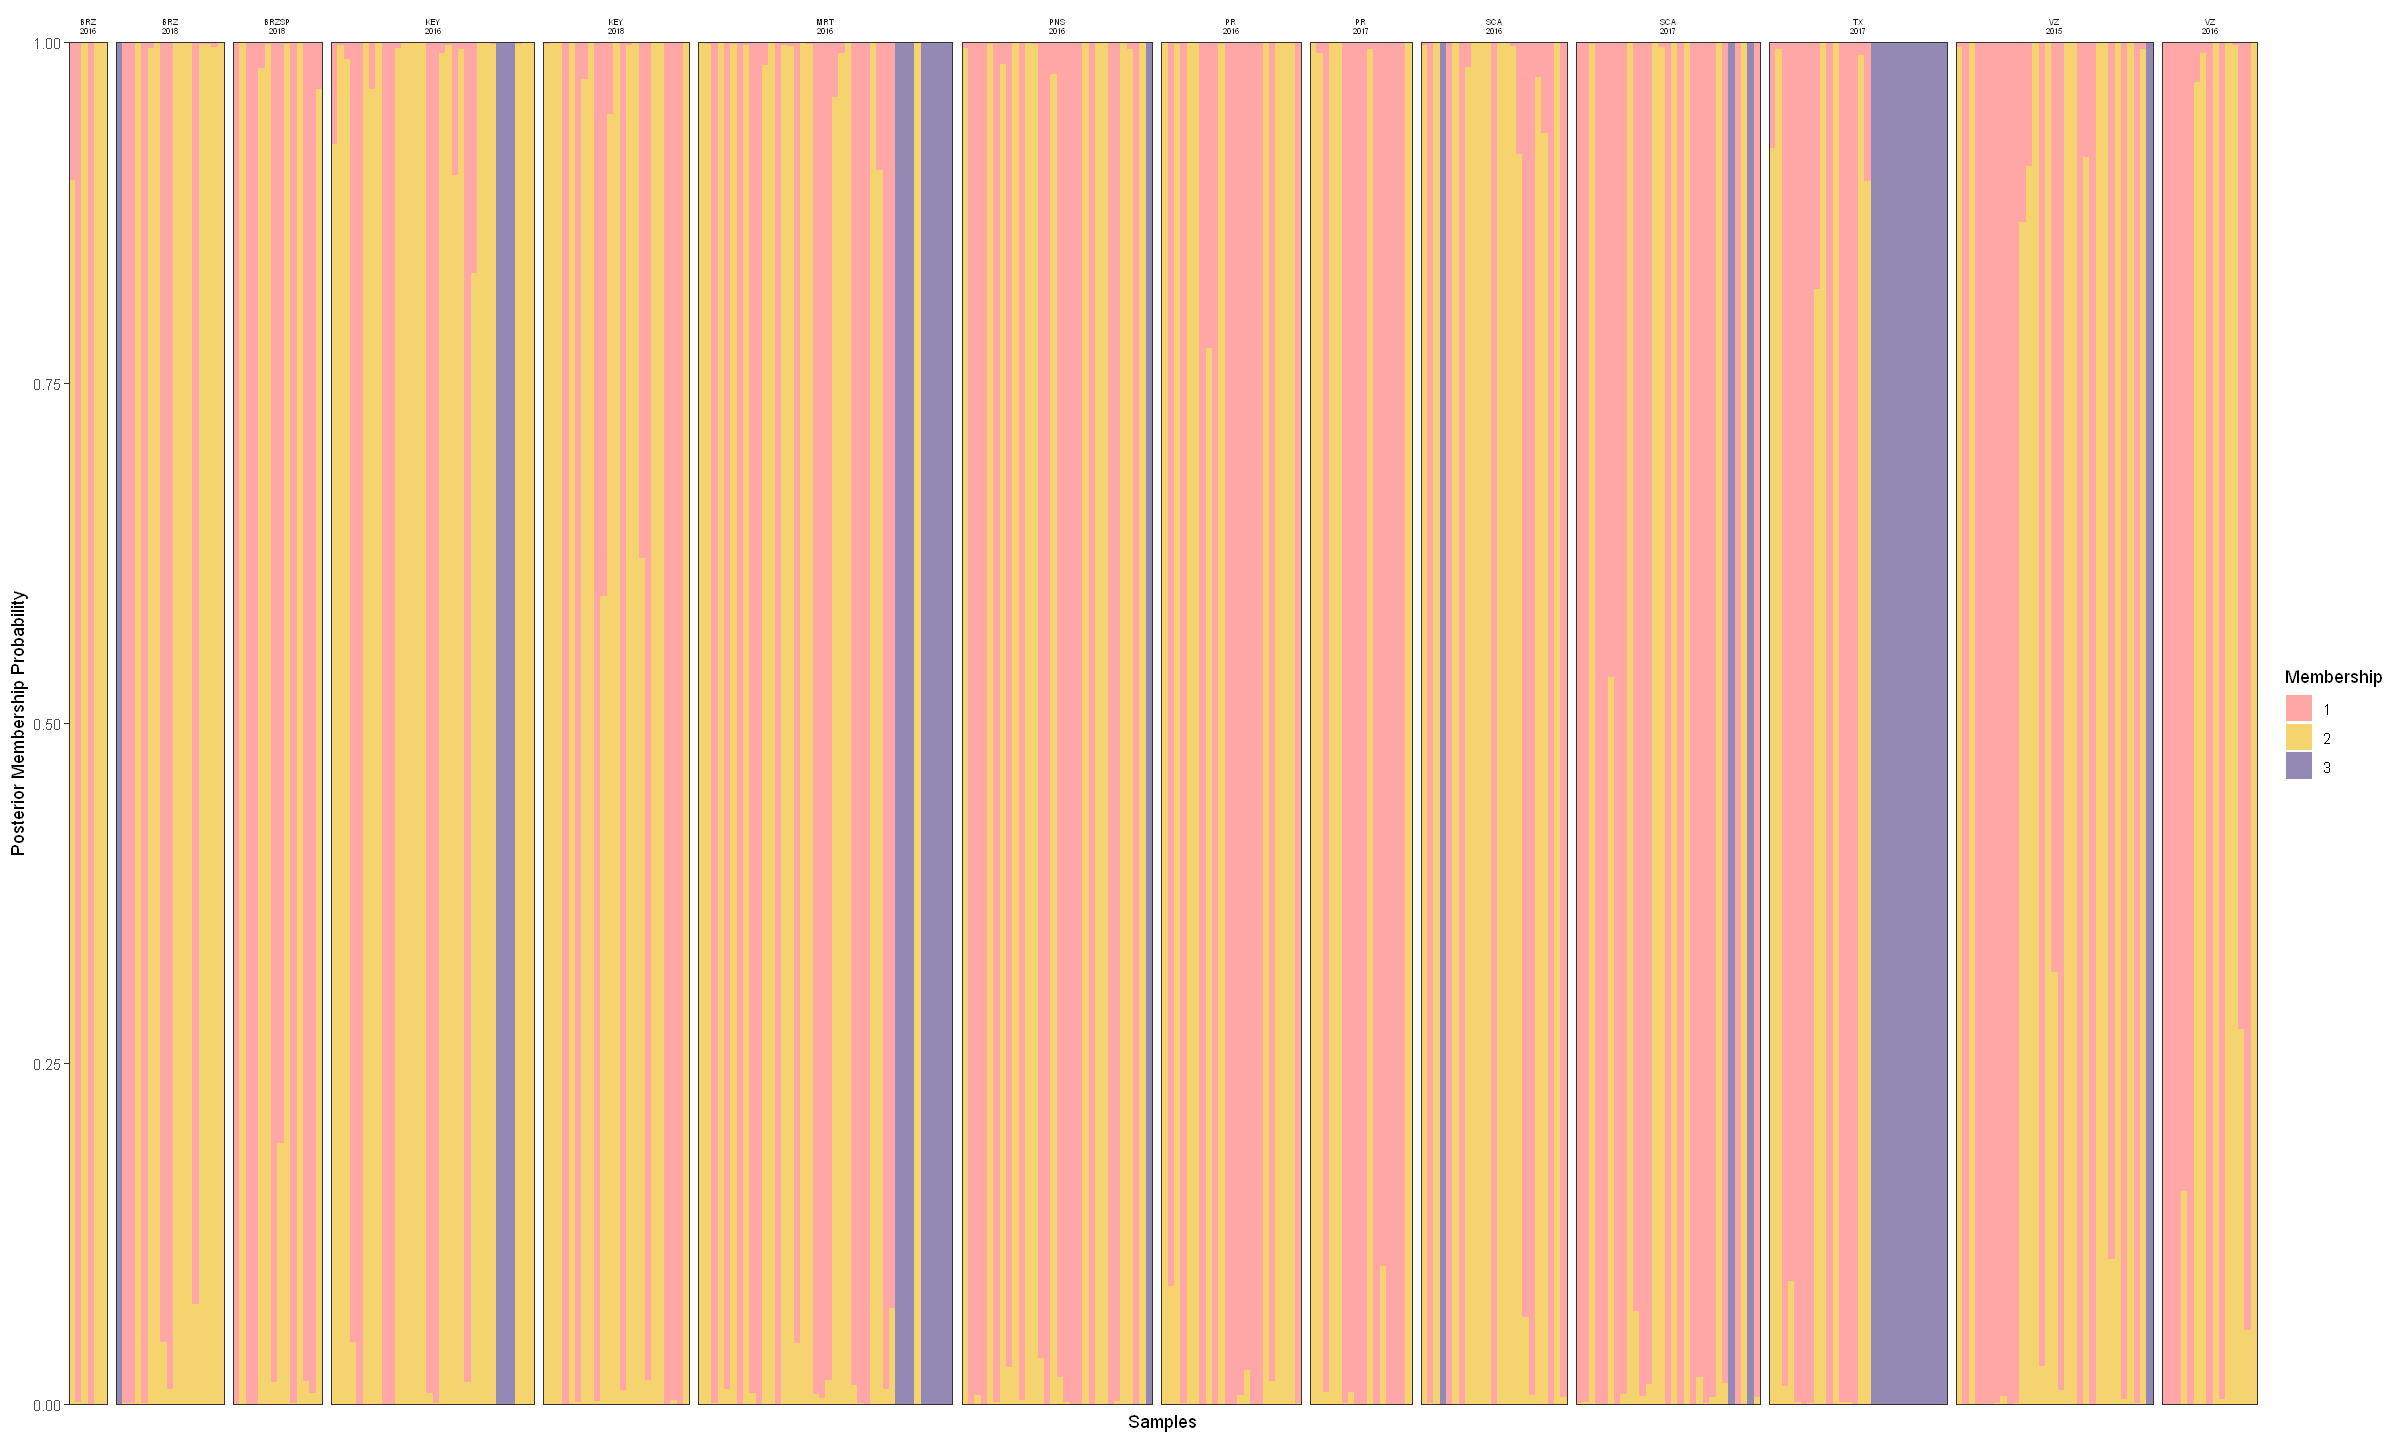

In [85]:
posterior_plot <- assignments %>% 
  ggplot(aes(x = name, y = posterior, fill = assignment)) +
  geom_bar(stat = "identity", width = 1.0, alpha = 0.7) +
  scale_fill_manual(values = my_pal[c(9,1,4,6)]) +
  #scale_fill_manual(values=c(paste(my_pal, "98", sep = ""))) +
  ylab( "Posterior Membership Probability") +
  xlab("Samples") +
  facet_grid(~origin, scales = "free_x", space = "free" ) + 
  theme_bw() +
  guides(fill=guide_legend(title="Membership")) +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        strip.background = element_blank(),
        strip.text.x = element_text(size = 5)) +
  coord_cartesian(ylim = c(0, 1), expand = FALSE, clip = "off")

posterior_plot

Combine all three as a single plot

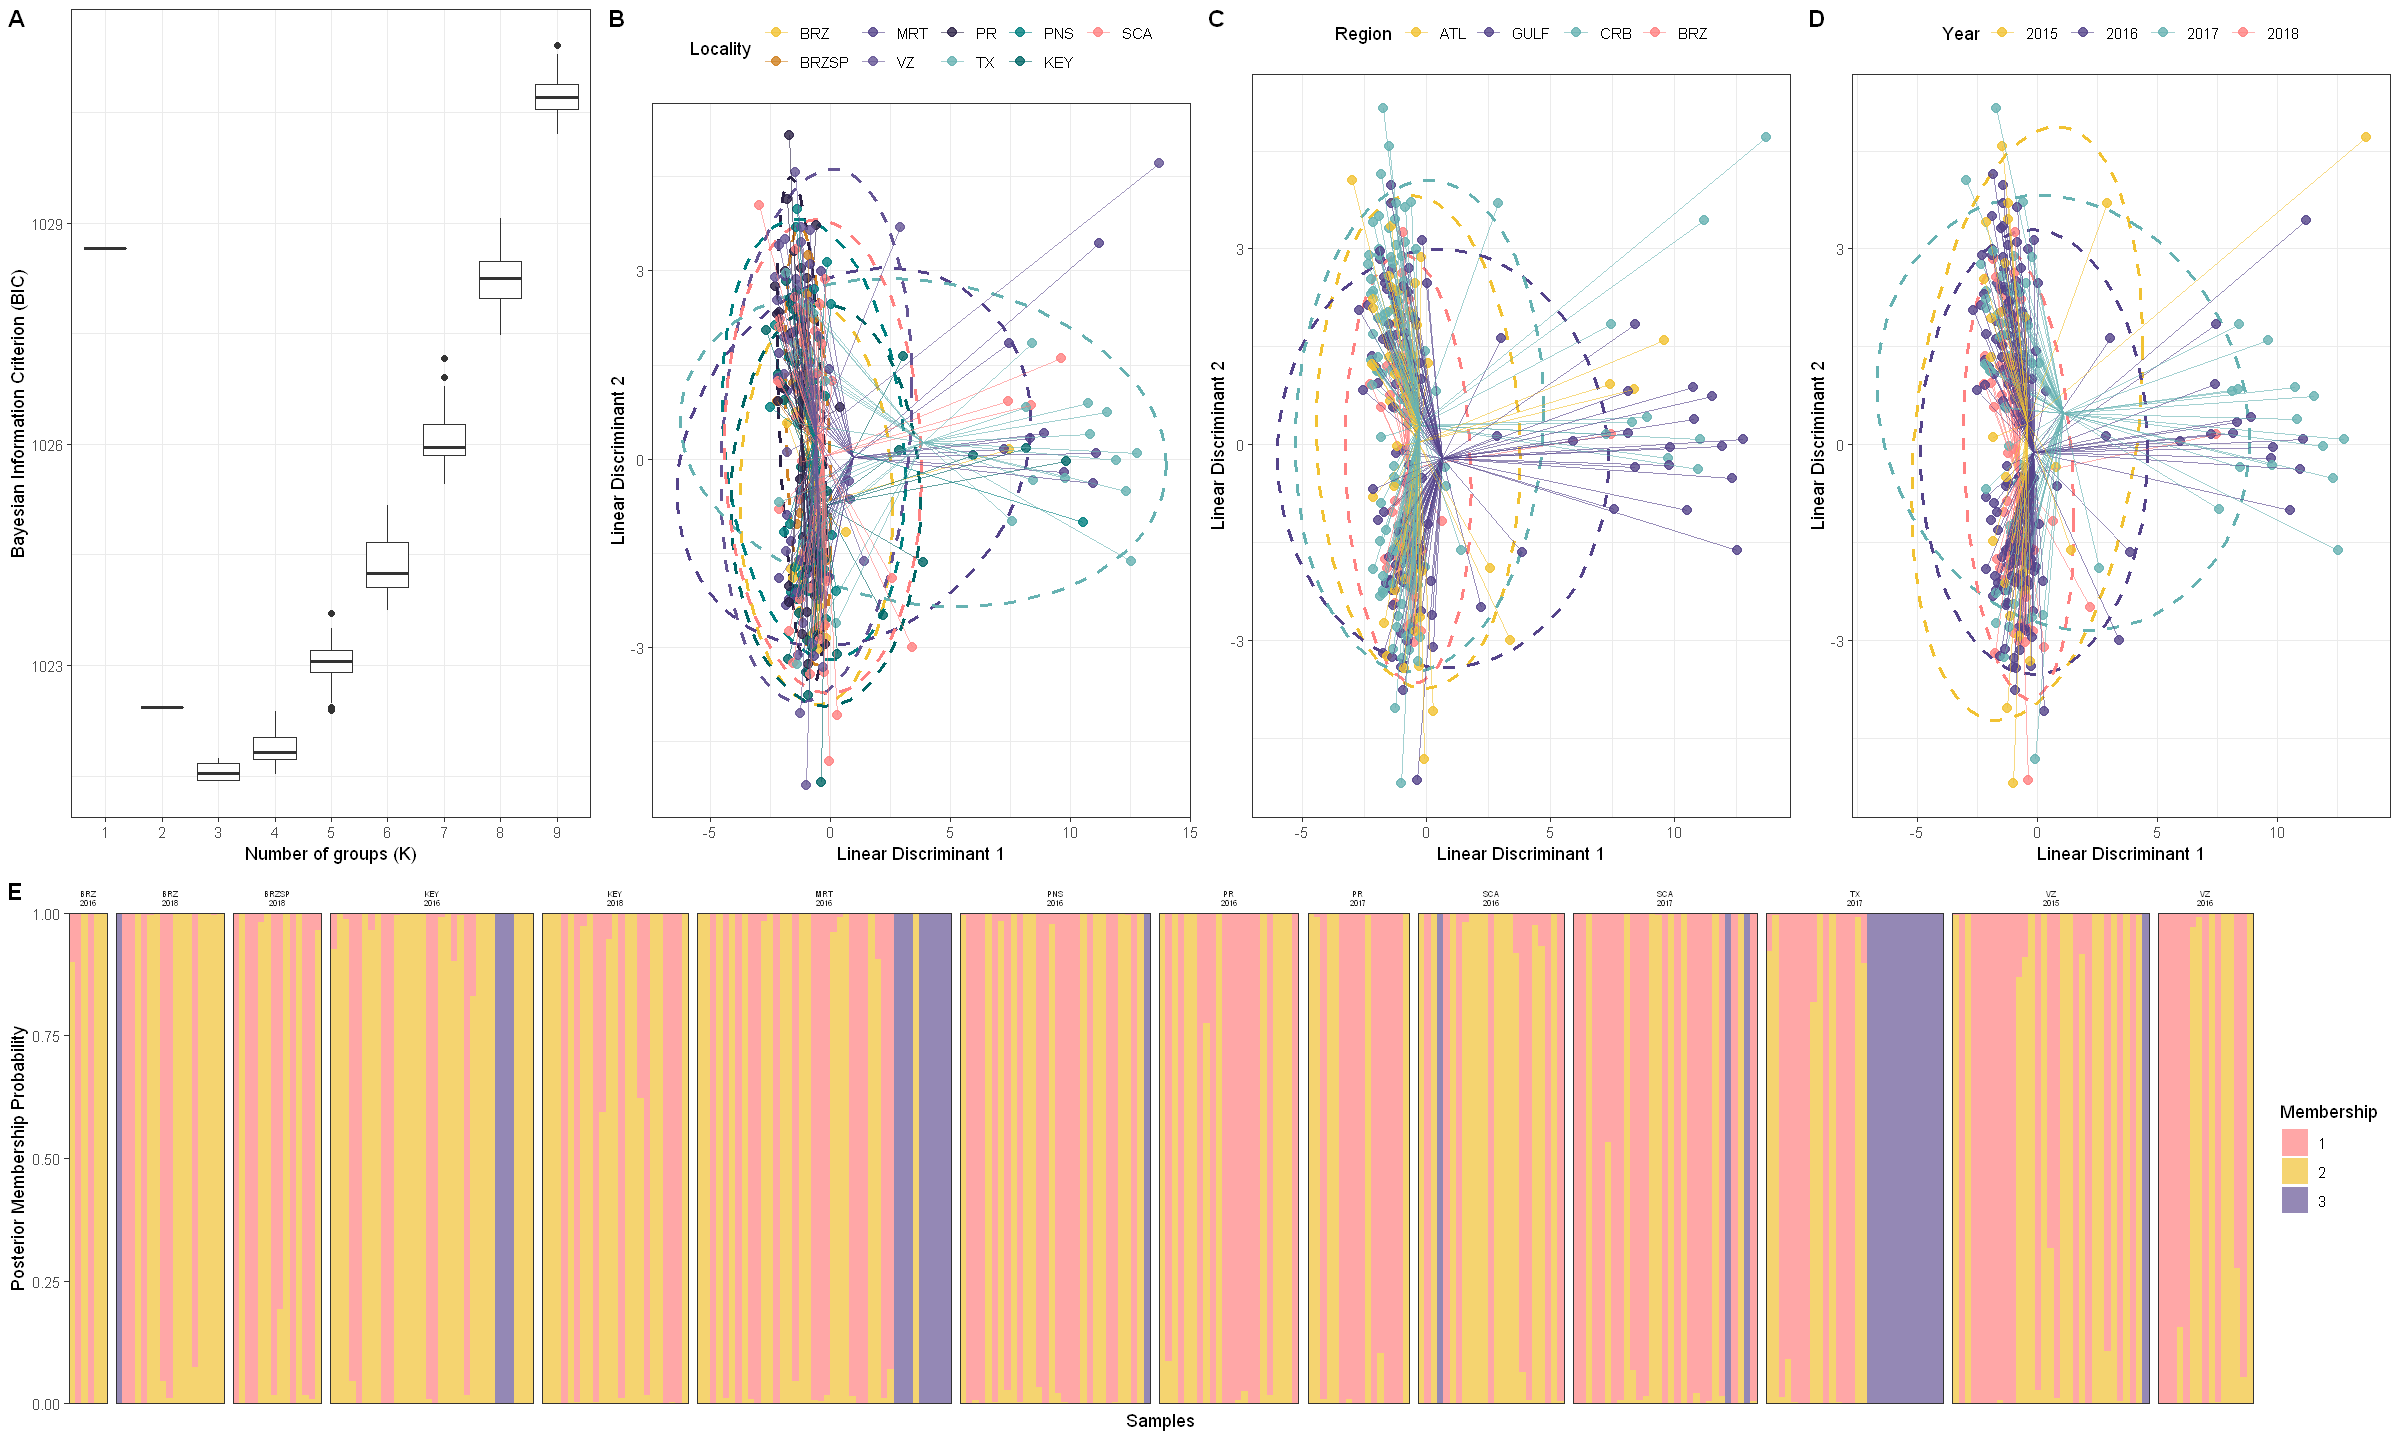

In [97]:
options(repr.plot.width=20, repr.plot.height=12)
ggarrange(
  ggarrange(
    k_plot,
    dapc.plt.loc,
    dapc.plt.region,
    dapc.plt.year,
    ncol = 4, 
    labels = c("A", "B", "C", "D")
    #widths = c(1,1.5)
  ),
  posterior_plot,
  nrow = 2,
  labels = c("", "E"),
  heights = c(2, 1.3)
)

Save it

In [98]:
ggsave("DAPC.png", height = 7, width = 14, units = "in")